# LSTM Stock Predictor Using Closing Prices

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin closing prices to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [165]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [166]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [167]:
# Load the fear and greed sentiment data for Bitcoin
btc_sent_df = pd.read_csv('btc_sentiment.csv', index_col = "date", infer_datetime_format = True, parse_dates = True)
btc_sent_df = btc_sent_df.drop(columns = "fng_classification")
btc_sent_df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [168]:
# Load the historical closing prices for Bitcoin
btc_price_hist_df = pd.read_csv('btc_historic.csv', index_col = "Date", infer_datetime_format = True, parse_dates = True)['Close']
btc_price_hist_df = btc_price_hist_df.sort_index()
btc_price_hist_df.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [169]:
# Join the data into a single DataFrame
combined_df = btc_sent_df.join(btc_price_hist_df, how = "inner")
combined_df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [170]:
combined_df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [171]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [200]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size_10 = 10
window_size_9 = 9
window_size_8 = 8
window_size_7 = 7
window_size_6 = 6 
window_size_5 = 5
window_size_4 = 4
window_size_3 = 3
window_size_2 = 2
window_size_1 = 1

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(combined_df, window_size_1, feature_column, target_column)

In [201]:
# Use 70% of the data for training and the remaineder for testing
split = int(len(X) * 0.70)
X_train = X[:split -1]
X_test = X[split:]
y_train = y[:split -1]
y_test = y[split:]

In [202]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [203]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]} \n")

X_train sample values:
[[[0.60761794]]

 [[0.58242373]]

 [[0.62172321]]

 [[0.51499412]]

 [[0.38267307]]] 

X_test sample values:
[[[0.03974167]]

 [[0.04528668]]

 [[0.04528668]]

 [[0.07024855]]

 [[0.07145402]]] 



---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [204]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [205]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 30
dropout_fraction = .2

# Layer 1 
model.add(LSTM(units = number_units, return_sequences = True, input_shape = (X_train.shape[1],1)))
model.add(Dropout(dropout_fraction))

# Layer 2 
model.add(LSTM(units = number_units, return_sequences = True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units = number_units))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [206]:
# Compile the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [207]:
# Summarize the model
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 1, 30)             3840      
_________________________________________________________________
dropout_34 (Dropout)         (None, 1, 30)             0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 1, 30)             7320      
_________________________________________________________________
dropout_35 (Dropout)         (None, 1, 30)             0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_36 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)               

In [208]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train,y_train,epochs = 10, shuffle = False, batch_size = 1, verbose = 1)

Epoch 1/10
377/377 [==============================] - 5s 3ms/step - loss: 0.1332
Epoch 2/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0676
Epoch 3/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0507
Epoch 4/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0317
Epoch 5/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0211
Epoch 6/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0154
Epoch 7/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0097
Epoch 8/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0098
Epoch 9/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0075
Epoch 10/10
377/377 [==============================] - 1s 3ms/step - loss: 0.0072


---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [209]:
# Evaluate the model
model.evaluate(X_test,y_test)

6/6 [==============================] - 1s 2ms/step - loss: 0.0270


0.027038784697651863

In [210]:
# Make some predictions
predicted = model.predict(X_test)

In [211]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [212]:
# Create a DataFrame of Real and Predicted values
combined = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = combined_df.index[-len(real_prices): ]) 
combined.head()

,Real,Predicted
2019-02-17,3670.919922,3575.964355
2019-02-18,3670.919922,3613.731201
2019-02-19,3912.570068,3613.731201
2019-02-20,3924.239990,3783.804932
2019-02-21,3974.050049,3792.019043


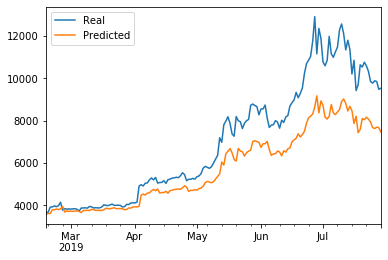

In [213]:
# Plot the real vs predicted values as a line chart
combined.plot()

In [94]:
print("The closing price model with a 10 day window and a batch size of 1 has a loss of 0.05698740482330322")
print("The closing price model with a 9 day window and a batch size of 1has a loss of 0.05794268101453781")
print("The closing price model with a 8 day window and a batch size of 1 has a loss of 0.05436614155769348")
print("The closing price model with a 7 day window and a batch size of 1 has a loss of 0.05647362023591995")
print("The closing price model with a 6 day window and a batch size of 1 has a loss of 0.04773198068141937")
print("The closing price model with a 5 day window and a batch size of 1 has a loss of 0.05169899761676788")
print("The closing price model with a 4 day window and a batch size of 1 has a loss of 0.04490302875638008")
print("The closing price model with a 3 day window and a batch size of 1 has a loss of 0.042218562215566635")
print("The closing price model with a 2 day window and a batch size of 1 has a loss of 0.03205731883645058")
print("The closing price model with a 1 day window and a batch size of 1 has a loss of 0.027038784697651863")

The closing price model with a 10 day window and a batch size of 1 has a loss of 0.05698740482330322
The closing price model with a 9 day window and a batch size of 1has a loss of 0.05794268101453781
The closing price model with a 8 day window and a batch size of 1 has a loss of 0.05698740482330322
The closing price model with a 7 day window and a batch size of 1 has a loss of 0.05698740482330322
The closing price model with a 6 day window and a batch size of 1 has a loss of 0.05698740482330322
The closing price model with a 5 day window and a batch size of 1 has a loss of 0.05698740482330322
The closing price model with a 4 day window and a batch size of 1 has a loss of 0.05698740482330322
The closing price model with a 3 day window and a batch size of 1 has a loss of 0.05698740482330322
The closing price model with a 2 day window and a batch size of 1 has a loss of 0.05698740482330322
The closing price model with a 1 day window and a batch size of 1 has a loss of 0.05698740482330322


In [220]:
print("In running both models with 10 day window and a batch size of 1, the closing price model has the smaller loss of 0.05698740482330322")

In running both models with 10 day window and a batch size of 1, both models yielded a loss of 0.05698740482330322


In [216]:
print("The closing price model tracks the actual values better over time as indicated by the graph.")
print("The pattern of actual vs predicted is almost the same over timefor the closing prices and radically different for FNG.")

The closing price model tracks the actual values better over time as indicated by the graph.
The pattern of actual vs predicted is almost the same over time.


In [221]:
print("The closing price model with a 1 day window and a batch size of 1 has a loss of 0.027038784697651863 is the best performing model.")
print("The fng model with a 5 day window and batch size of 1 has a loss of 0.10695990920066833, which is the smalles loss of all windows between 1 and 10.")

The closing price model with a 1 day window and a batch size of 1 has a loss of 0.027038784697651863 is the best performing model.
The fng model with a 5 day window and batch size of 1 has a loss of 0.10695990920066833, which is the smalles loss of all windows between 1 and 10.


# Which model has a lower loss?
*The closing price model had the lower loss.*
# Which model tracks the actual values better over time?
*The closing price model tracks the actual values better over time.*
# Which window size works best for the model?
*A window size of 1 works best for the closing price model and a window size of 5 works best for the FNG model.*